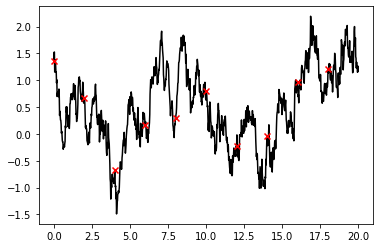

In [359]:
import numpy as np
from matplotlib import pyplot as plt

def ou_cov(sigma, gamma, t, t_):
    
    coeff = 0.5 * sigma ** 2 / gamma
    exp = np.exp(- gamma * np.abs(t[..., :, None] - t_[..., None, :]))
    
    return coeff * exp


t0 = 0.
t1 = 20.

sigma = 1.
gamma = 1.

num_pts = 1000
idx = num_pts // 10

np.random.seed(0)

t = np.linspace(t0, t1, num_pts)
x_mean = np.zeros((num_pts,))
x_cov = ou_cov(sigma=sigma, gamma=gamma, t=t, t_=t)

x = np.random.multivariate_normal(mean=x_mean, cov=x_cov)

plt.plot(t, x, color='k', zorder=1)
plt.scatter(t[::idx], x[::idx], marker='x', color='red', zorder=2)

In [415]:
def forward(m0, S0, b, A, Sigma, dt):

    m = m0 * np.ones((num_pts, 1))
    S = S0 * np.ones((num_pts, 1, 1))
    
    for i in range(len(b) - 1):
        
        m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
        S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
        
    return m, S


def backward(b, A, m, S, Sigma, gamma, psi, lamda, t, x, dt):
    
    b_ = b[:]
    A_ = A[:]

    for i in range(len(b) - 1, 0, -1):
        
        coeff = (A[i] - gamma) ** 2 / Sigma ** 2
        dEds2 = 0.5 * coeff
        dEdm = coeff * m[i] - b[i] * (A[i] - gamma) / Sigma ** 2
        rm1n
        psi[i - 1] = psi[i] - (2 * np.dot(psi[i], A[i]) - dEds2) * dt
        lamda[i - 1] = lamda[i] - (np.dot(A[i].T, lamda[i]) - dEdm) * dt
        
        if i - 1 in t:
            psi[i - 1] = psi[i - 1] + 0.5 * Sigma ** -2
            lamda[i - 1] = lamda[i - 1] - Sigma ** -2 * (x[t[i - 1]] - m[i - 1])
            
    for i in range(len(b) - 1, -1, -1):
        A_[i] = gamma + 2 * np.dot(Sigma, psi[i])
        b_[i] = - gamma * m[i] + np.dot(A_[i], m[i]) - np.dot(Sigma, lamda[i])
            
    return psi, lamda, b_, A_


def smoothing(t_train, x_train, num_passes, omega, Sigma, gamma, dt):
    
    # Dictionary mapping from time indices to x_train indices
    t_train = dict(zip(t_train, np.arange(0, len(t_train))))
    
    b = np.ones((num_pts, 1))
    A = np.ones((num_pts, 1, 1))

    m = x_train[0] * np.ones((num_pts, 1))
    S = np.ones((num_pts, 1, 1))
    
    psi = None
    lamda = None
    
    for i in range(num_passes):

        lamda = np.zeros((num_pts, 1))
        psi = np.zeros((num_pts, 1, 1))
        
        # Forward pass to compute m, S
        m, S = forward(m0=x_train[0], S0=0., b=b, A=A, Sigma=Sigma, dt=dt)
        
        print(b)
        # Backward pass to compute psi, lamda, b_, A_
        psi, lamda, b_, A_ = backward(b=b,
                                      A=A,
                                      m=m,
                                      S=S,
                                      Sigma=Sigma,
                                      gamma=gamma,
                                      psi=psi,
                                      lamda=lamda,
                                      t=t_train,
                                      x=x_train,
                                      dt=dt)
        print(b)
        
#         b = b + omega * (b_ - b)
#         A = A + omega * (A_ - A)

    return b, A, m, S, psi, lamda

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

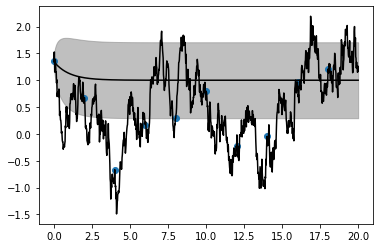

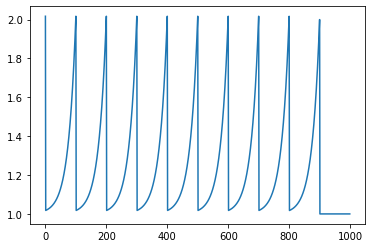

In [416]:
t_train = np.arange(0, num_pts, idx)
x_train = x[t_train]
num_passes = 1
omega = 0.
Sigma = 1. * np.eye(1)
gamma = 1

b, A, m, S, psi, lamda = smoothing(t_train=t_train,
                                   x_train=x_train,
                                   num_passes=num_passes,
                                   omega=omega,
                                   Sigma=Sigma,
                                   gamma=gamma,
                                   dt=dt)


plt.plot(t, m[:, 0], color='k')
plt.fill_between(t,
                 m[:, 0] - S[:, 0, 0] ** 0.5,
                 m[:, 0] + S[:, 0, 0] ** 0.5,
                 color='gray',
                 alpha=0.5)
plt.scatter(t[::idx], x[::idx])
plt.plot(t, x, color='k', zorder=1)
plt.show()

plt.plot(A[:, 0, 0])
plt.show()
# plt.plot(b[:, 0])
# plt.show()
# plt.plot(psi[:, 0])
# plt.show()
# plt.plot(lamda[:, 0])
# plt.show()

In [391]:
t_train

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])